  Pathway  Score_median  Score_zscore  TCGA-86-8672  TCGA-78-7166  \
1     Age -1.003911e-19     -7.419285 -3.817179e-18 -3.758106e-18   

   TCGA-50-5939  TCGA-55-8505  TCGA-62-A46Y  TCGA-97-8179  TCGA-05-4434  ...  \
1 -1.955051e-20 -2.177923e-15 -1.802762e-15 -7.169006e-20 -7.452980e-13  ...   

   TCGA-50-5072  TCGA-62-A46O  TCGA-62-8399  TCGA-86-7953  TCGA-55-6979  \
1 -2.829896e-15 -6.596677e-21 -1.492783e-15 -6.967619e-20 -1.639085e-17   

   TCGA-NJ-A4YG  TCGA-78-7153  TCGA-86-7714  TCGA-69-7979  TCGA-64-5775  
1 -4.527820e-20 -4.566636e-20 -5.501734e-15 -2.527539e-20 -4.780897e-15  

[1 rows x 509 columns]
Down median survival time:  1081.0
Up median survival time:  2318.0
Down median survival time:  1081.0
Up median survival time:  2318.0
Down median survival time:  1081.0
Up median survival time:  2318.0
Down median survival time:  2318.0
Up median survival time:  1081.0
Down median survival time:  2318.0
Up median survival time:  1046.0
Down median survival time:  2318.0
Up

/tmp/ipykernel_3132/4188858974.py:95: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(1,1, figsize=(5,4))


Down median survival time:  2620.0
Up median survival time:  999.0
Down median survival time:  2318.0
Up median survival time:  1046.0
Down median survival time:  2620.0
Up median survival time:  1043.0
Down median survival time:  2620.0
Up median survival time:  1043.0
Down median survival time:  1043.0
Up median survival time:  2620.0
Down median survival time:  2620.0
Up median survival time:  1046.0
  Pathway  Score_median  Score_zscore  TCGA-86-8672  TCGA-78-7166  \
1     Age -5.242974e-18    -13.273537 -3.373596e-16 -4.013126e-17   

   TCGA-50-5939  TCGA-55-8505  TCGA-62-A46Y  TCGA-97-8179  TCGA-05-4434  ...  \
1 -1.339737e-18 -2.480287e-15 -2.357035e-15 -3.180501e-18 -3.730129e-14  ...   

   TCGA-50-5072  TCGA-62-A46O  TCGA-62-8399  TCGA-86-7953  TCGA-55-6979  \
1 -7.688509e-15 -4.021790e-18 -1.182031e-15 -6.462738e-18 -6.212962e-17   

   TCGA-NJ-A4YG  TCGA-78-7153  TCGA-86-7714  TCGA-69-7979  TCGA-64-5775  
1 -2.341351e-18 -2.898018e-18 -2.554851e-15 -1.192833e-18 -5.020989e

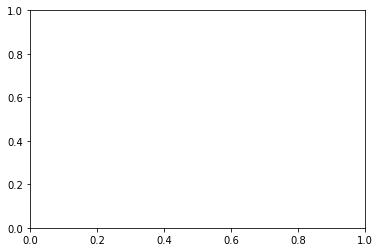

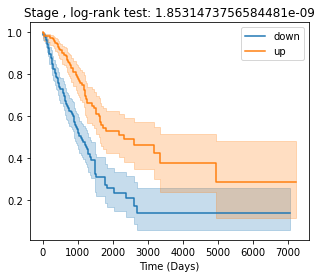

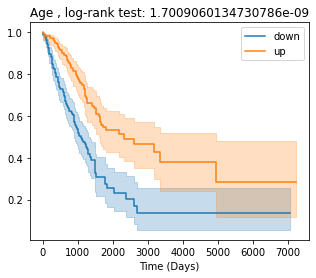

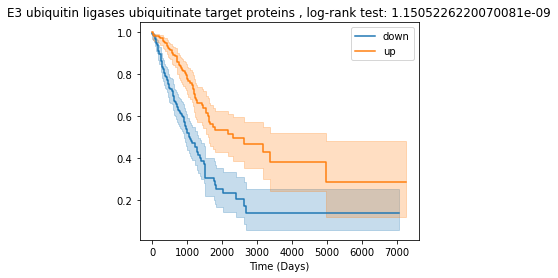

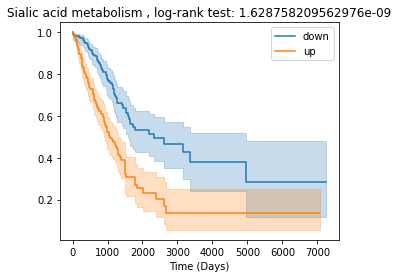

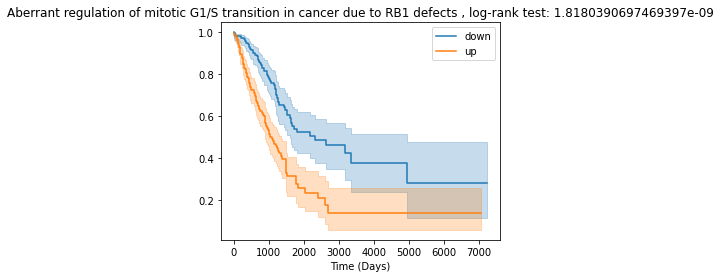

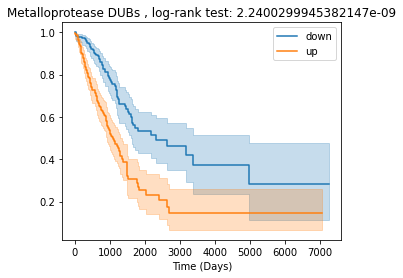

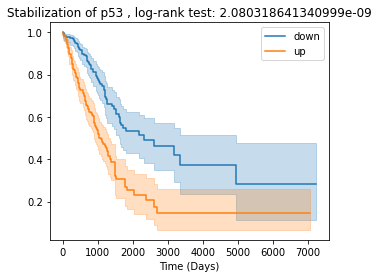

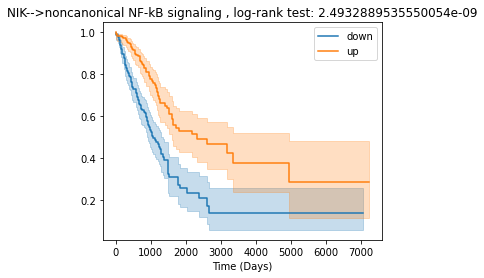

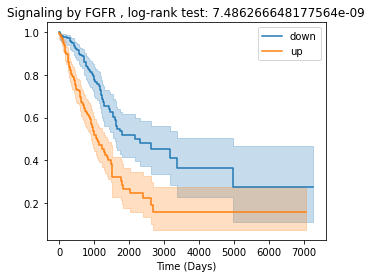

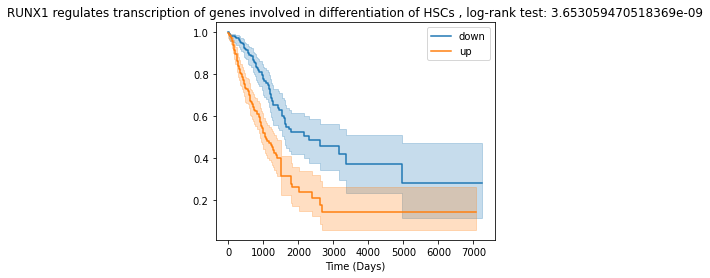

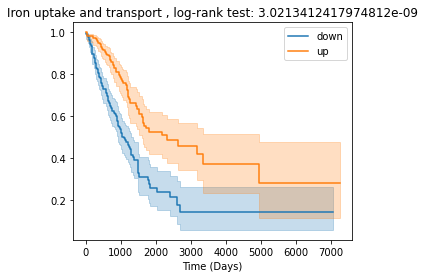

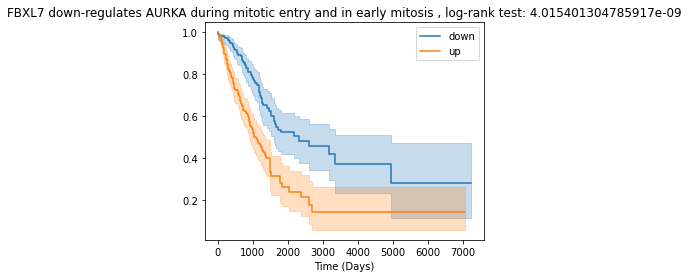

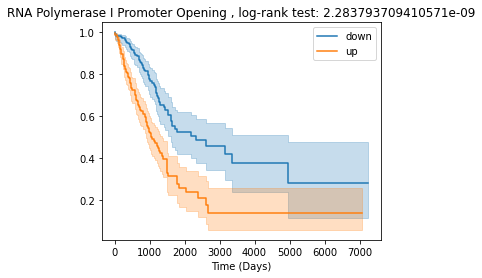

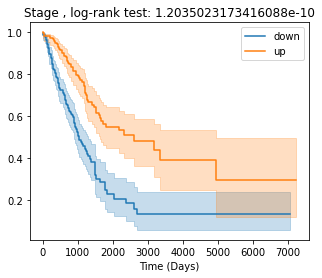

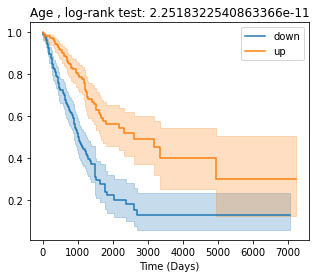

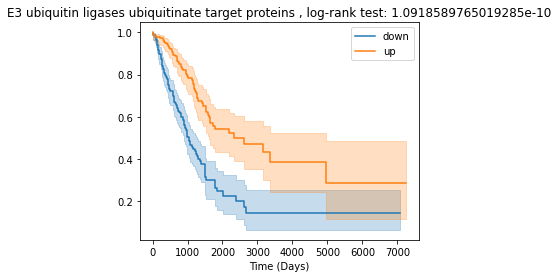

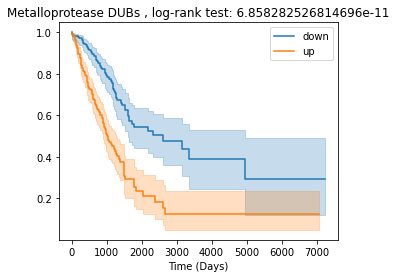

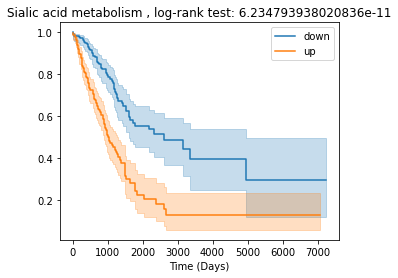

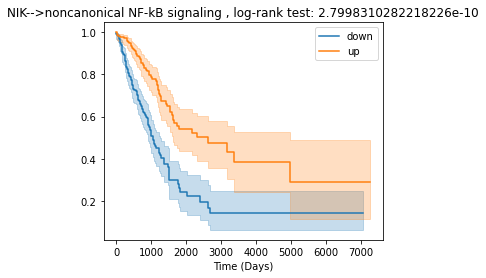

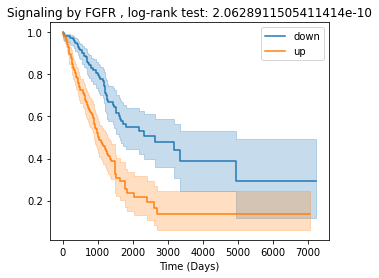

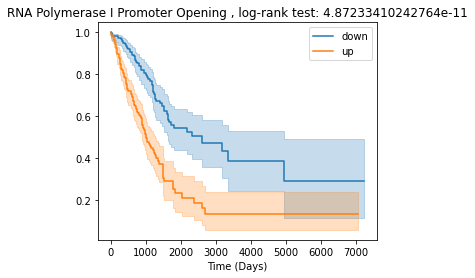

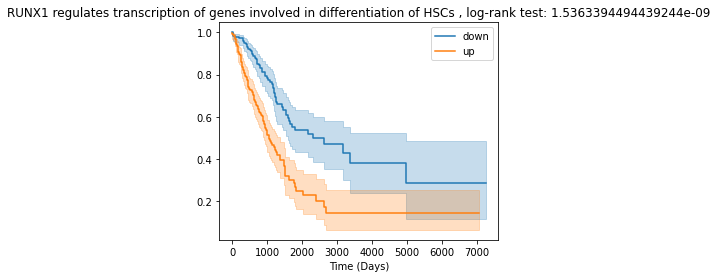

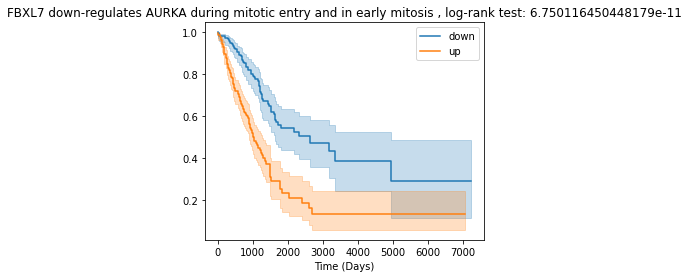

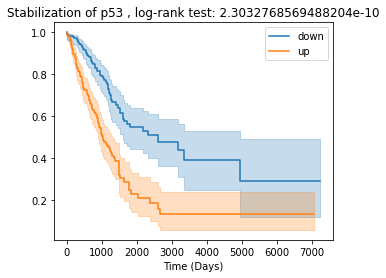

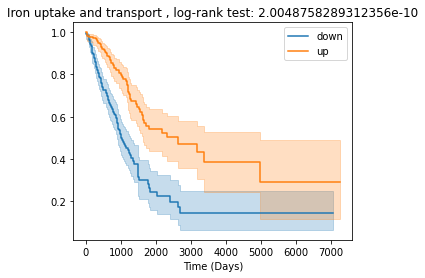

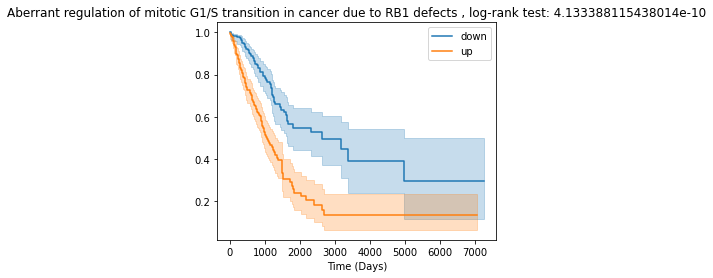

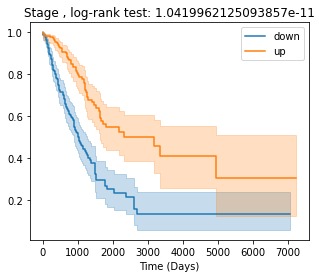

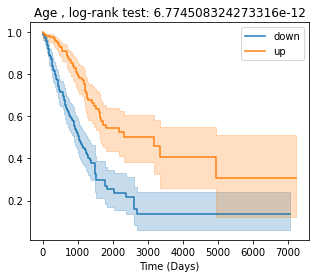

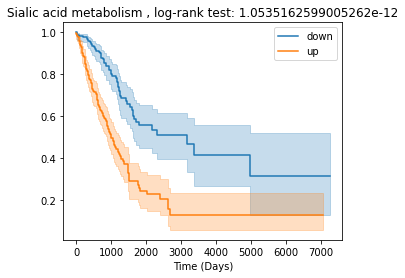

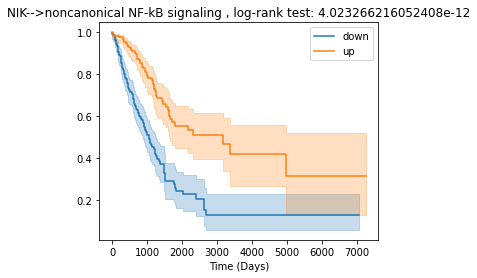

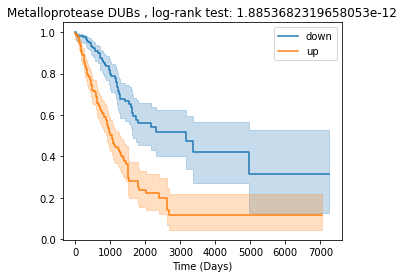

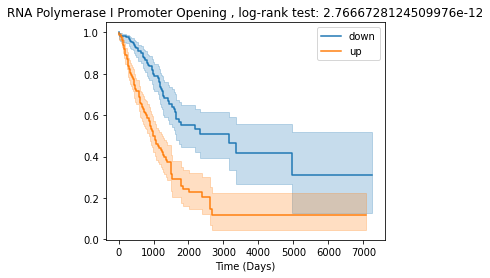

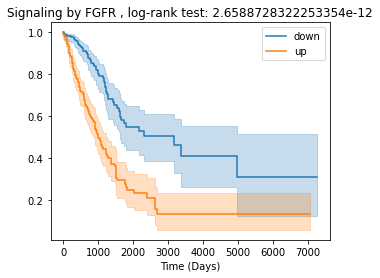

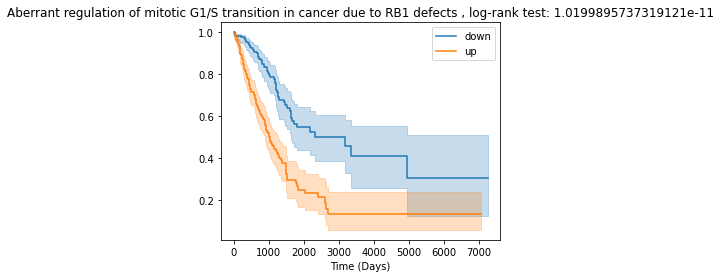

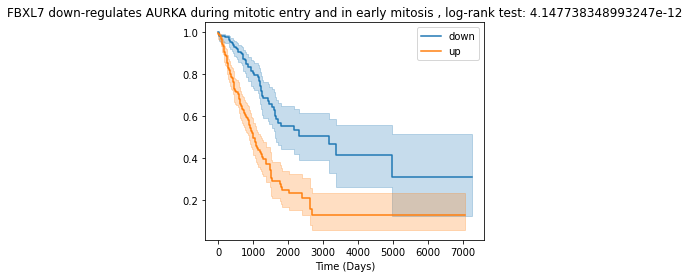

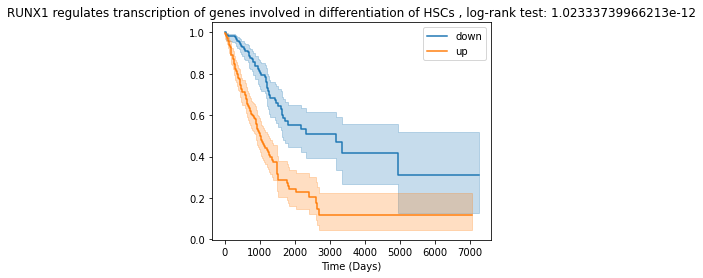

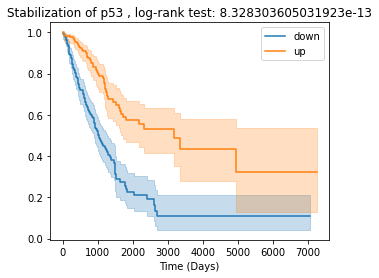

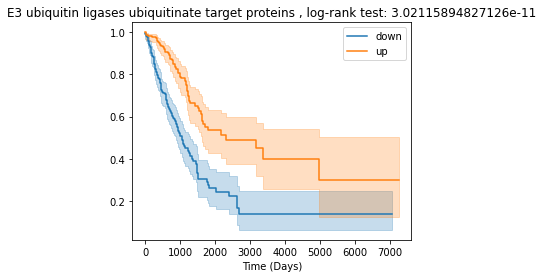

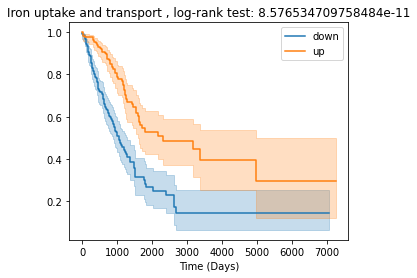

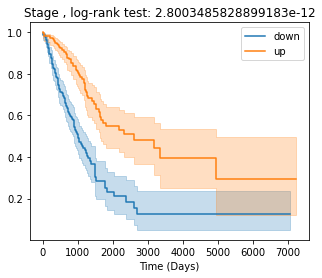

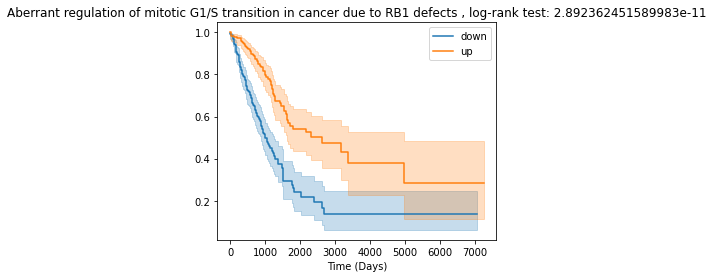

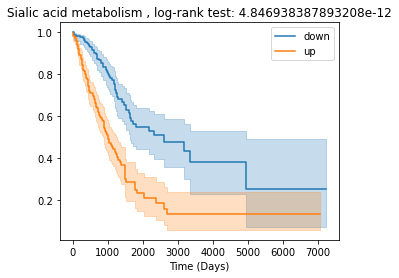

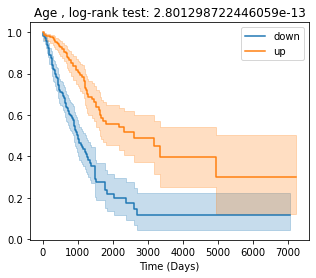

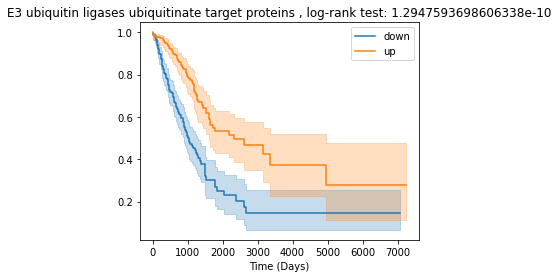

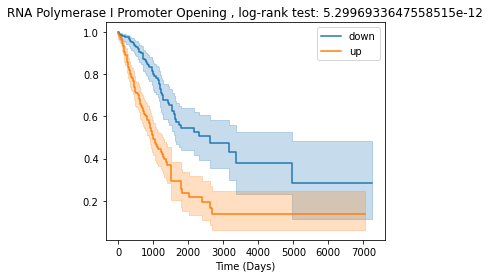

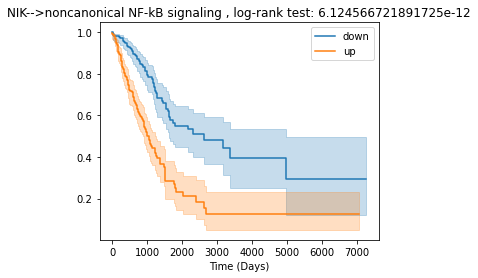

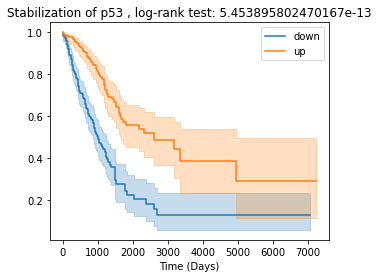

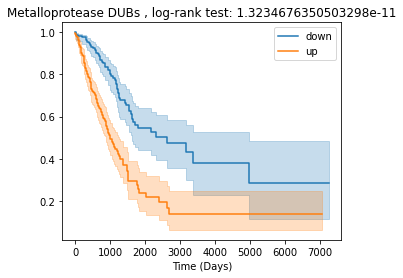

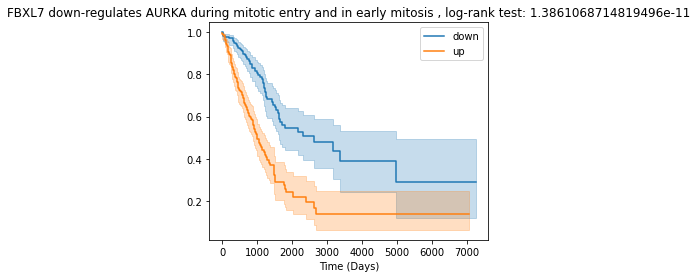

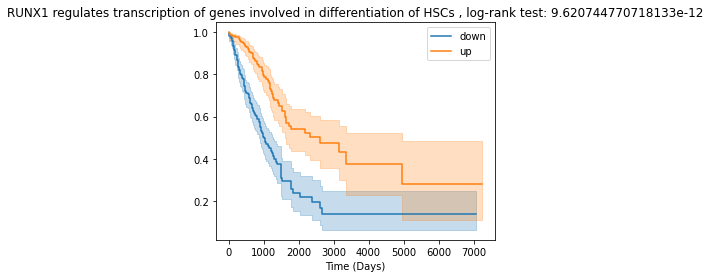

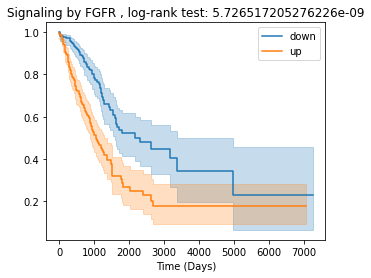

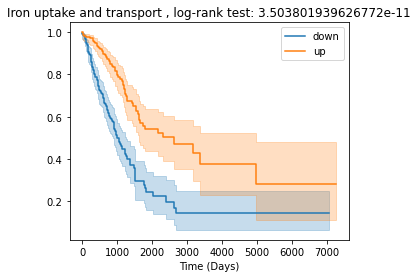

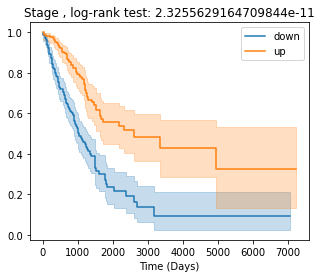

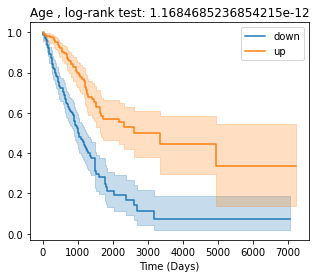

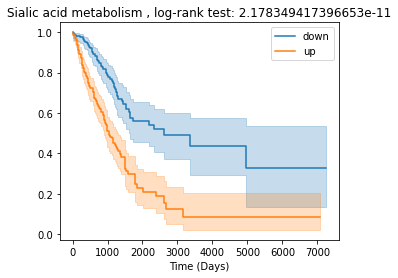

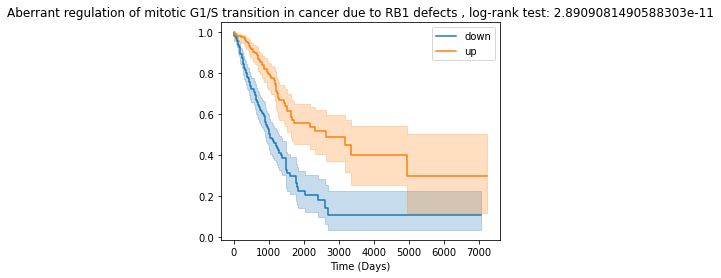

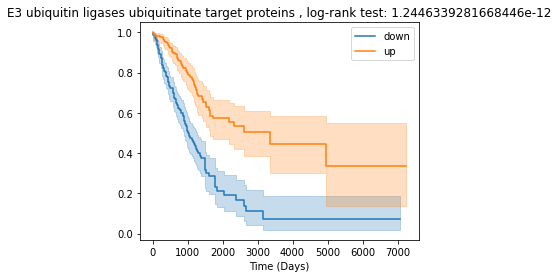

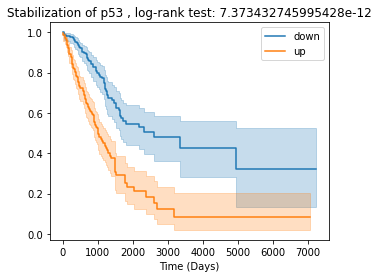

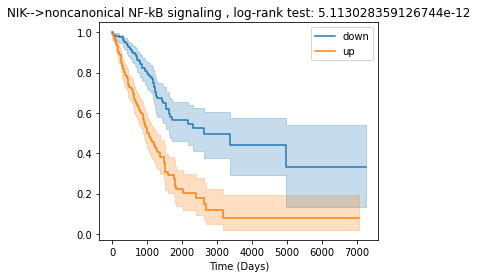

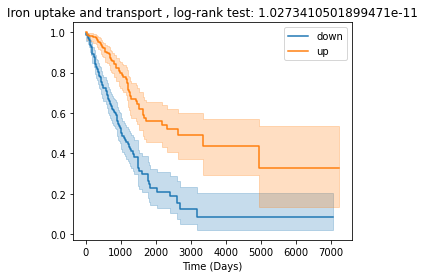

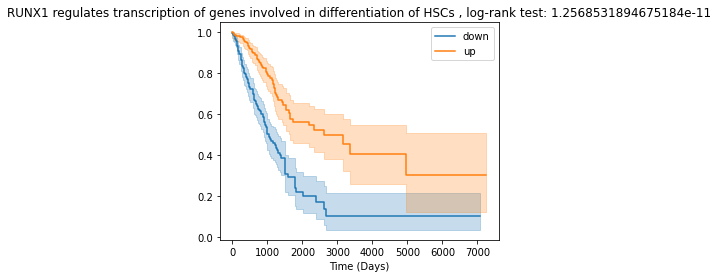

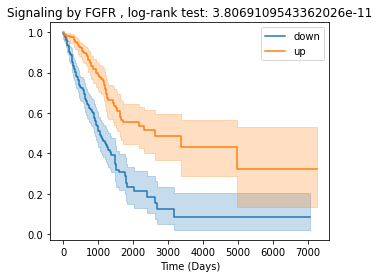

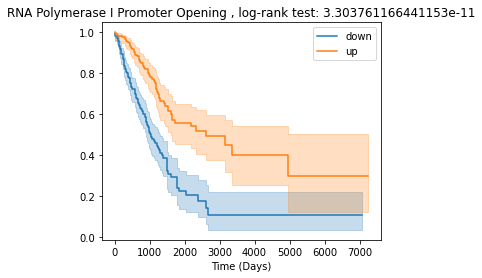

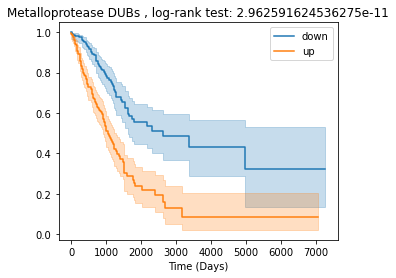

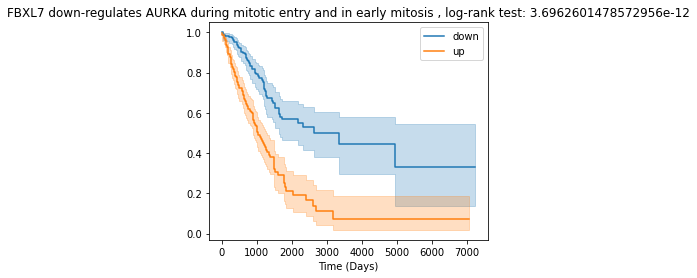

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

project = 'KIRC'
df_cli = pd.read_table('Data/LUAD/clean/clinical.txt')
df_pathway = pd.read_excel('./IG_merge.xlsx')
pathways_ = df_pathway[df_pathway.Cancer == project].Pathway.to_list()
pathways_ += ['Age', 'Stage']

# df_predict = df_predict[df_predict.Score_zscore.abs() > 1.5]

df_out = pd.DataFrame(columns=['Pathway', 'Project'])
df_out = df_out.set_index('Pathway')


def jiaozheng(df_predict):
    df_predict_ = df_predict[df_predict.Pathway == 'Age']
    print(df_predict_)
    for idx, row in df_predict_.iterrows():
        pathway = row[0]
        score_median = row[1]
        smp_idx = 0
        group1 = []
        group2 = []
        for value in row[3:]:
            if value < score_median:
                group1.append(smps[smp_idx])
            else:
                group2.append(smps[smp_idx])
            smp_idx += 1

        df_cli_group1 = df_cli[df_cli.Patient_ID.isin(group1)]
        df_cli_group2 = df_cli[df_cli.Patient_ID.isin(group2)]

        # pvalue: log-rank test
        results=logrank_test(df_cli_group1.Time, df_cli_group2.Time,
                             event_observed_A=df_cli_group1.Status, 
                             event_observed_B=df_cli_group2.Status)
        pvalue = results.p_value

        kmf = KaplanMeierFitter()
        ax = plt.subplot(111)
        kmf.fit(df_cli_group1.Time, event_observed=df_cli_group1.Status,label='down')
        down_median = kmf.median_survival_time_

        kmf.fit(df_cli_group2.Time, event_observed=df_cli_group2.Status,label='up')
        up_median = kmf.median_survival_time_

    if up_median > down_median:
        return 0
    else:
        return 1
        

for fold in [1,2,3,4,5]:
    df_predict = pd.read_table('Results/LUAD/feature_importance.tsv.fold{}.tsv'.format(fold))
    df_predict = df_predict[df_predict.Pathway.isin(pathways_)]
    smps = df_predict.columns.to_list()[3:]
    
    # standard by age
    jiaozheng1 = jiaozheng(df_predict)
            
    for idx, row in df_predict.iterrows():
        pathway = row[0]
        score_median = row[1]
        smp_idx = 0
        group1 = []
        group2 = []
        for value in row[3:]:
            if value < score_median:
                group1.append(smps[smp_idx])
            else:
                group2.append(smps[smp_idx])
            smp_idx += 1
        
        if jiaozheng1 == 1:
            group_tmp = group1
            group1 = group2
            group2 = group_tmp
        
        df_cli_group1 = df_cli[df_cli.Patient_ID.isin(group1)]
        df_cli_group2 = df_cli[df_cli.Patient_ID.isin(group2)]

        # pvalue: log-rank test
        results=logrank_test(df_cli_group1.Time, df_cli_group2.Time,
                             event_observed_A=df_cli_group1.Status, 
                             event_observed_B=df_cli_group2.Status)
        pvalue = results.p_value

        # plot
        kmf = KaplanMeierFitter()
#         ax = plt.subplot(111)
        fig, ax = plt.subplots(1,1, figsize=(5,4))
        kmf.fit(df_cli_group1.Time, event_observed=df_cli_group1.Status,label='down')
        kmf.plot(ax=ax)
        print('Down median survival time: ', kmf.median_survival_time_)
        down_median = kmf.median_survival_time_

        kmf.fit(df_cli_group2.Time, event_observed=df_cli_group2.Status,label='up')
        kmf.plot(ax=ax)
        print('Up median survival time: ', kmf.median_survival_time_)
        up_median = kmf.median_survival_time_

        plt.title(pathway + ' , log-rank test: {}'.format(pvalue))
        plt.xlabel('Time (Days)')
        pathway = pathway.replace(' ', '')
        pathway = pathway.replace('/', '_')
        fig.savefig('Results/{}/pdf/'.format(project) + pathway.replace(' ', '') + '.Fold{}.pdf'.format(fold))
#         plt.show()
        
        # prepare output
        if down_median < up_median:
            non_LTS = 'down'
            LTS = 'up'
            non_LTS_median = down_median
            LTS_median = up_median
        else:
            non_LTS = 'up'
            LTS = 'down'
            non_LTS_median = up_median
            LTS_median = down_median

        if pvalue < 0.001:
            pvalue = '<0.001'
        else:
            pvalue = round(pvalue, 3)
        # out table
        df_out.loc[pathway, 'Project'] = project
        df_out.loc[pathway, 'non-LTS_Fold{}'.format(fold)] = non_LTS
        df_out.loc[pathway, 'LTS_Fold{}'.format(fold)] = LTS
        df_out.loc[pathway, 'Pvalue_Fold{}'.format(fold)] = pvalue
        df_out.loc[pathway, 'non-LTS_median_time_Fold{}'.format(fold)] = non_LTS_median
        df_out.loc[pathway, 'LTS_median_time_Fold{}'.format(fold)] = LTS_median
df_out.to_csv('Results/{}.IG.stat.tsv'.format(project), index=True, sep='\t')

In [49]:
df_out.to_csv('Results/{}.IG.stat.tsv'.format(project), index=True, sep='\t')

In [23]:
df_predict.

,Pathway,Score_median,Score_zscore,TCGA-86-8672,TCGA-78-7166,TCGA-50-5939,TCGA-55-8505,TCGA-62-A46Y,TCGA-97-8179,TCGA-05-4434,...,TCGA-50-5072,TCGA-62-A46O,TCGA-62-8399,TCGA-86-7953,TCGA-55-6979,TCGA-NJ-A4YG,TCGA-78-7153,TCGA-86-7714,TCGA-69-7979,TCGA-64-5775
0,Stage,1.700739e-16,15.723324,1.251614e-15,2.105154e-15,8.404947e-17,5.260696e-14,1.559347e-14,5.932710e-17,2.286004e-12,...,2.509110e-14,2.524290e-17,1.743592e-13,1.167545e-16,6.266715e-15,7.798166e-17,3.956087e-17,2.457839e-14,1.036695e-16,4.593095e-14
1,Age,1.449042e-16,13.389138,4.639940e-16,1.119757e-15,9.020290e-17,1.359017e-14,4.601416e-15,5.406924e-17,4.767571e-13,...,7.728372e-15,2.103666e-17,4.559083e-14,1.028203e-16,2.332529e-15,6.404245e-17,3.253755e-17,6.332311e-15,9.356618e-17,1.363272e-14
2,Transcriptional regulation of white adipocyte ...,8.037615e-17,7.404942,2.444765e-16,4.647935e-16,3.085443e-17,8.283424e-15,1.787647e-15,2.805805e-17,2.438355e-13,...,4.016620e-15,8.280767e-18,2.517073e-14,4.881310e-17,9.987095e-16,3.804301e-17,1.559136e-17,4.762361e-15,4.773187e-17,5.599690e-15
3,Opioid Signalling,7.456756e-17,6.866265,2.032362e-16,5.429944e-16,3.094874e-17,6.843812e-15,2.053336e-15,2.863501e-17,2.812936e-13,...,2.481239e-15,7.154438e-18,2.449430e-14,4.413839e-17,1.298739e-15,2.759202e-17,1.297531e-17,3.651518e-15,5.194783e-17,7.137304e-15
4,Sialic acid metabolism,-6.553505e-17,-6.126553,-1.918524e-16,-4.138173e-16,-4.356075e-17,-6.663183e-15,-2.264717e-15,-2.290398e-17,-2.259796e-13,...,-2.910580e-15,-1.002572e-17,-2.235542e-14,-5.320950e-17,-1.018234e-15,-2.738527e-17,-1.531935e-17,-2.816026e-15,-4.291418e-17,-6.634439e-15
5,Aberrant regulation of mitotic G1/S transition...,5.234943e-17,4.805804,1.988993e-16,3.057655e-16,2.460571e-17,5.416151e-15,1.651774e-15,1.508647e-17,1.682528e-13,...,2.453286e-15,7.532526e-18,1.747993e-14,3.308827e-17,9.884550e-16,2.000700e-17,1.396004e-17,3.078615e-15,3.267330e-17,4.533363e-15
6,"Platelet activation, signaling and aggregation",4.788946e-17,4.392195,1.760227e-16,2.761924e-16,2.663388e-17,3.726091e-15,1.491754e-15,1.776882e-17,1.897289e-13,...,1.970682e-15,7.689819e-18,1.799406e-14,3.734522e-17,9.319413e-16,2.179718e-17,1.032461e-17,2.003920e-15,3.146959e-17,3.717891e-15
7,B-WICH complex positively regulates rRNA expre...,4.550046e-17,4.170644,1.459883e-16,3.073858e-16,1.921176e-17,3.224710e-15,1.305081e-15,1.639874e-17,1.592835e-13,...,1.755093e-15,7.318190e-18,1.389415e-14,3.948111e-17,7.534673e-16,2.180390e-17,1.023815e-17,1.970116e-15,2.973421e-17,3.956830e-15
8,Collagen formation,-3.916905e-17,-3.681427,-1.443628e-16,-2.639902e-16,-2.539226e-17,-4.490776e-15,-1.063243e-15,-1.463796e-17,-1.427595e-13,...,-2.037085e-15,-5.645439e-18,-1.473887e-14,-2.767128e-17,-8.405208e-16,-1.828948e-17,-1.086121e-17,-2.378790e-15,-2.645244e-17,-3.914379e-15
9,Amino acids regulate mTORC1,3.445315e-17,3.146140,1.227831e-16,1.423430e-16,1.950764e-17,2.882375e-15,6.530485e-16,1.151720e-17,1.465785e-13,...,1.259901e-15,3.703588e-18,1.355235e-14,2.938158e-17,8.069962e-16,7.909952e-18,6.041676e-18,1.206101e-15,1.622574e-17,2.189449e-15


In [10]:
pathway | project | non-LTS | LTS | Pvalue | non-LTS-median_time | LTS-median_time

3169.0